# French incremental death analysis, day-to-day

## Objective

The goal of this notebook is to use the INSEE death records to estimate the number of death caused by Covid-19, using incremental techniques.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

plt.rcParams['figure.figsize'] = (21, 14)

Populating the interactive namespace from numpy and matplotlib


## Prepare data

### INSEE data

In [167]:
# load data
death_logs = pd.read_parquet('../data/processed/death/insee_date-place-age-gender_1970_to_20200427.parquet')

In [3]:
death_logs.head()  # as you can see, lots of weird death before 1970

,,,,nb_death
date_death,insee_code_death,age,gender,
1882-10-01,72077,0,F,1
1886-10-01,85092,0,F,1
1889-07-04,97105,0,F,1
1889-10-06,24322,0,F,1
1890-07-16,64360,0,M,1


In [168]:
# we only need death logs from 2010 onward
death_logs = death_logs.reset_index()
death_logs_recent = death_logs.query('date_death >= "2010-01-01" |  date_death.dt.year == 2003')

# we'll also not focus on age nor gender
death_day_place = death_logs.groupby(['date_death', 'insee_code_death']).agg({'nb_death': 'sum'}).reset_index()

In [170]:
# we have a discrepancy between historical and weekly updates data:
# - in historical data, death from non-DOM collectivities (starting with 98) and death on foreign soil (starting with 99) are counted
# - in weekly updates, they are not
# we'll remove the lines where insee_code_death starts with 98 and 99
death_day_place = death_day_place[~death_day_place.insee_code_death.str[:2].isin({'98', '99'})]

In [171]:
# we can now safely group by date
death_day = death_day_place.groupby(['date_death'], as_index=False).agg({'nb_death': 'sum'})

### Official death count

In [122]:
death_official_raw = pd.read_csv('../data/raw/death/chiffres-cles.csv.gz')

In [123]:
death_official = death_official_raw.query('granularite == "pays" & source_type == "ministere-sante" & date >= "2020-03-01"').fillna(0.)

In [128]:
death_official['nb_death_cumulated'] = death_official.eval('deces + deces_ehpad')
death_official['nb_death'] = death_official.nb_death_cumulated.diff()
death_official.loc[death_official.index[0], 'nb_death'] = death_official.nb_death_cumulated.iloc[0]
death_official['date'] = pd.to_datetime(death_official.date)

## Incremental analysis

In [172]:
# a trick for year-on-year comparison purposes: forge a fake date with the year replaced by the leap-year of your choice
# this way, you can overlay everything like it was the same year
# for easier grouping and plotting, keep the real year in a column apart

death_day['fake_date'] = death_day.date_death.apply(lambda x: x.replace(year=2012))
death_day['year'] = death_day.date_death.dt.year

death_official['fake_date'] = death_official.date.apply(lambda x: x.replace(year=2012))

In [173]:
# compute 2010-2019 average
death_day_avg = death_day[~death_day.year.isin({2003, 2020})].groupby('fake_date', as_index=False).agg({'nb_death': 'mean'})

In [51]:
# set periods of interest
heatwave_2003 = lambda x: (x >= '2012-08-02') & (x <= '2012-08-16')
covid_19 = lambda x: (x >= '2012-03-01') & (x < '2012-05-11')

In [174]:
# estimate death counts

# 2003 heatwave, for reference:
data = death_day[(death_day.year == 2003) & (heatwave_2003(death_day.fake_date))]
death_count_2003 = data['nb_death'].sum() - death_day_avg[death_day_avg.fake_date.isin(data.fake_date)]['nb_death'].sum()
print('2003 heatwave: ~{:,.0f} deaths'.format(round(death_count_2003, -3)))

# 2020 Covid-19:
data = death_day[(death_day.year == 2020) & (covid_19(death_day.fake_date))]
death_count_covid19 = data['nb_death'].sum() - death_day_avg[death_day_avg.fake_date.isin(data.fake_date)]['nb_death'].sum()
print('Covid-19: ~{:,.0f} deaths (as of Apr 27)'.format(round(death_count_covid19, -3)))

2003 heatwave: ~14,000 deaths
Covid-19: ~26,000 deaths (as of Apr 27)


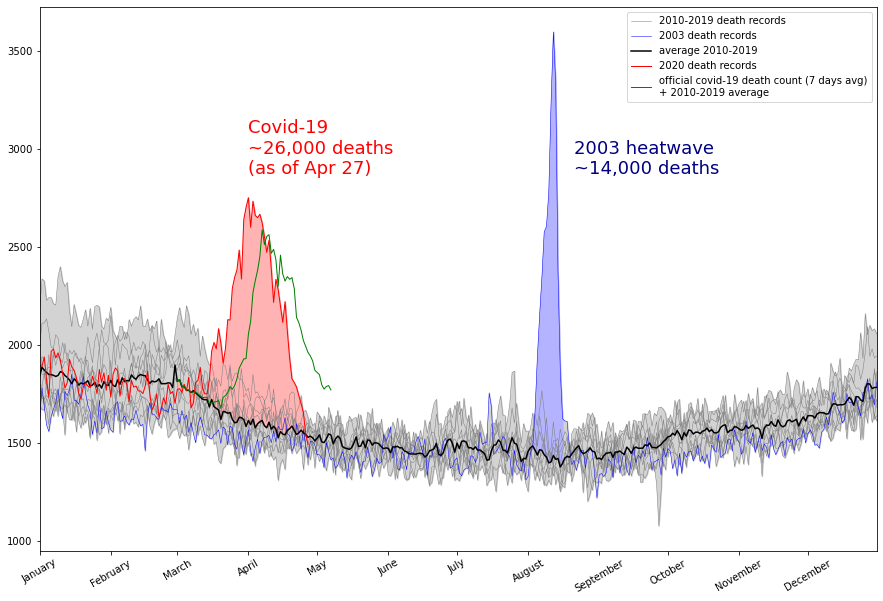

In [178]:
fig = figure(figsize=(15, 10), facecolor='w')

# plot yearly data
for year in range(2010, 2020):  # excluding 2020
    data = death_day[death_day.year == year]
    data_avg = death_day_avg[death_day_avg.fake_date.isin(data.fake_date)]  # restrict to dates found in current year
    fill_between(data.fake_date, data_avg.nb_death, data.nb_death, color='lightgray')
    plot(data.fake_date, data.nb_death, 'gray', linewidth=0.5, **({'label': '2010-2019 death records'} if year == 2010 else {}))

# 2003 (heatwave)
data = death_day[death_day.year == 2003]
data_avg = death_day_avg[death_day_avg.fake_date.isin(data.fake_date)]  # restrict to dates found in current year
fill_between(data.fake_date, data_avg.nb_death, data.nb_death, color='lightgray')
fill_between(data[heatwave_2003(data.fake_date)].fake_date, data_avg[heatwave_2003(data_avg.fake_date)].nb_death, data[heatwave_2003(data.fake_date)].nb_death, color=(0.7,0.7,1.))
plot(data.fake_date, data.nb_death, 'blue', linewidth=0.5, label='2003 death records')

# plot average
plot(death_day_avg.fake_date, death_day_avg.nb_death, color='black', label='average 2010-2019')

# 2020 (Covid-19)
data = death_day[death_day.year == 2020]
data_avg = death_day_avg[death_day_avg.fake_date.isin(data.fake_date)]  # restrict to dates found in current year
fill_between(data.fake_date, data_avg.nb_death, data.nb_death, color='lightgray')
fill_between(data[covid_19(data.fake_date)].fake_date, data_avg[covid_19(data_avg.fake_date)].nb_death, data[covid_19(data.fake_date)].nb_death, color=(1.,0.7,0.7))
plot(data.fake_date, data.nb_death, 'red', linewidth=1., label='2020 death records')

# official counts
plot(
    death_official.fake_date,
    death_official.nb_death.rolling(7, min_periods=1).mean().values
    + death_day_avg[death_day_avg.fake_date.isin(death_official.fake_date)].nb_death.values,
    'green', linewidth=1., label='official covid-19 death count (7 days avg)\n+ 2010-2019 average'
)


# prettify plot
ax = gca()
xlim((np.datetime64('2012-01-01'), np.datetime64('2012-12-31')))
annotate(
    'Covid-19\n~{:,.0f} deaths\n(as of Apr 27)'.format(round(death_count_covid19, -3)),
    ((np.datetime64('2012-04-01'), 2850)),
    ha='left', va='bottom',
    color='red', fontsize=18
)
annotate(
    '2003 heatwave\n~{:,.0f} deaths'.format(round(death_count_2003, -3)),
    ((np.datetime64('2012-08-21'), 2850)),
    ha='left', va='bottom',
    color='navy', fontsize=18
)

legend()
# tick_labels = ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre', '']
tick_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
xticks(ticks=np.asarray(death_day_avg.fake_date[death_day_avg.fake_date.dt.is_month_start].values).astype('datetime64[D]'), labels=tick_labels, rotation=30, ha='center');


In [155]:
Text?

Init signature:
Text(
    x=0,
    y=0,
    text='',
    color=None,
    verticalalignment='baseline',
    horizontalalignment='left',
    multialignment=None,
    fontproperties=None,
    rotation=None,
    linespacing=None,
    rotation_mode=None,
    usetex=None,
    wrap=False,
    **kwargs,
)
Docstring:      Handle storing and drawing of text in window or data coordinates.
Init docstring:
Create a `.Text` instance at *x*, *y* with string *text*.

Valid keyword arguments are:

Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
    alpha: float or None
    animated: bool
    backgroundcolor: color
    bbox: dict with properties for `.patches.FancyBboxPatch`
    clip_box: `.Bbox`
    clip_on: bool
    clip_path: Patch or (Path, Transform) or None
    color or c: color
    contains: callable
    figure: `.Figure`
    fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}


In [158]:
matplotlib.font_manager.FontProperties(style='italic')

Init signature:
matplotlib.font_manager.FontProperties(
    family=None,
    style=None,
    variant=None,
    weight=None,
    stretch=None,
    size=None,
    fname=None,
)
Docstring:     
A class for storing and manipulating font properties.

The font properties are those described in the `W3C Cascading
Style Sheet, Level 1
<http://www.w3.org/TR/1998/REC-CSS2-19980512/>`_ font
specification.  The six properties are:

- family: A list of font names in decreasing order of priority.
  The items may include a generic font family name, either
  'serif', 'sans-serif', 'cursive', 'fantasy', or 'monospace'.
  In that case, the actual font to be used will be looked up
  from the associated rcParam.

- style: Either 'normal', 'italic' or 'oblique'.

- variant: Either 'normal' or 'small-caps'.

- stretch: A numeric value in the range 0-1000 or one of
  'ultra-condensed', 'extra-condensed', 'condensed',
  'semi-condensed', 'normal', 'semi-expanded', 'expanded',
  'extra-expanded' or 'ultra-expa